<a href="https://colab.research.google.com/github/lstival/mo443/blob/main/T4/T4_MO443.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import cv2

https://www.ic.unicamp.br/~helio/disciplinas/MO443/trabalho4.pdf

In [2]:
image_path = "https://www.ic.unicamp.br/~helio/imagens_png/"
image_name_pesp = "baboon_perspectiva.png"
image_name = "baboon.png"

In [3]:
img_pespective = io.imread(f"{image_path}{image_name_pesp}")
img = io.imread(f"{image_path}{image_name}")

Text(0.5, 1.0, 'Perspective image')

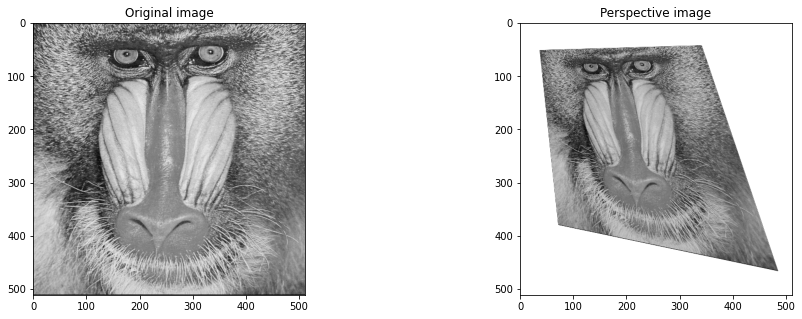

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(16,5))

axs[0].imshow(np.array(img), cmap='gray')
axs[0].set_title("Original image")

axs[1].imshow(np.array(img_pespective), cmap='gray')
axs[1].set_title("Perspective image")

 ## Perspective Projection

In [5]:
#https://acervolima.com/transformacao-de-perspectiva-python-opencv/

#Coordenadas originais da imagem transacionada
pts1 = np.float32([[37, 51], [342, 42], [485, 467], [73, 380]]) 

#Coordenadas para a nova projeção
pts2 = np.float32([[0, 0], [511, 0], [511, 511], [0, 511]]) 

Text(0.5, 1.0, "Transfomed image x'")

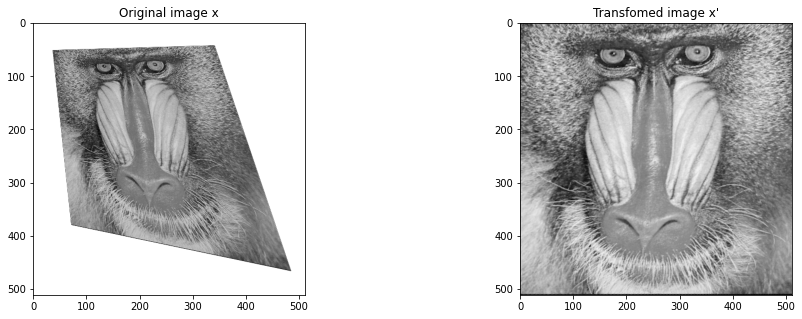

In [6]:
#Gerando a matriz contendo as perspectiva para transformação
matrix = cv2.getPerspectiveTransform(pts1, pts2)

#Nova imagem contendo as novas perspectivas
result = cv2.warpPerspective(img_pespective, matrix, img.shape)
#https://docs.opencv.org/4.x/da/d54/group__imgproc__transform.html#gaf73673a7e8e18ec6963e3774e6a94b87

fig, axs = plt.subplots(1, 2, figsize=(16,5))

axs[0].imshow(np.array(img_pespective), cmap='gray')
axs[0].set_title("Original image x")

axs[1].imshow(result[:,:,0], cmap='gray')
axs[1].set_title("Transfomed image x'")

In [8]:
#Gerando a matriz contendo as perspectiva para transformação
matrix2 = cv2.getPerspectiveTransform(pts2, pts1)

#Nova imagem contendo as novas perspectivas
result2 = cv2.warpPerspective(img, matrix2, img.shape)

In [9]:
def get_persp_points(p0, matrix):

  #Incluing the Z value to matmul.
  p0.extend([1])
  p1 = p0
  
  #Generate the x' value
  x = (p1[0] * matrix[0][0]) + (p1[1] * matrix[0][1]) + (p1[2] * matrix[0][2])

  #Generate the y' value
  y = (p1[0] * matrix[1][0]) + (p1[1] * matrix[1][1]) + (p1[2] * matrix[1][2])

  #Normalizin fator (W values)
  norm = (p1[0] * matrix[2][0]) + (p1[1] * matrix[2][1]) + (p1[2] * matrix[2][2])

  #Return a list with the values
  return [x/norm, y/norm]

In [10]:
get_persp_points([37, 51], matrix)

[1.3333681923417501e-14, 0.0]

In [11]:
heigth, width = img.shape

In [12]:
new_img = np.zeros((heigth, width), dtype=img.dtype)
get_persp_points([1, 2], matrix2)

[37.599970331832054, 52.02316579008745]

## Parâmetros para as transformações

In [ ]:
heigth, width = img.shape

In [ ]:
scale_factor = 3.73

In [ ]:
new_height = int(heigth * scale_factor)
new_width = int(width * scale_factor)

## Funções de apoio

In [32]:
def geometric_function(height, width, transform_function, 
                       interpolation_function, scale_factor=2):

  new_img = np.zeros((height, width), dtype=img.dtype)

  for line in range(height-8):
    for col in range(width-8):

      line_projected, col_projected = transform_function(line, col, scale_factor)
      
      pixel_value = interpolation_function(line_projected, col_projected, img)
      new_img[line, col] = pixel_value

  return new_img

In [14]:
def plot_transform(img, new_img):
  fig, axs = plt.subplots(1, 2, figsize=(16,5))

  axs[0].imshow(img, cmap='gray')
  axs[0].set_title("Imagem Original")

  axs[1].imshow(new_img, cmap='gray')
  axs[1].set_title("Com escala aplicada")

## Interpolações

Abaixo serão implementadas as técnicas de interpolação solicitadas na descrição do problema e verificado o MSE entre os valores do pixels originais (imagem fornecida sem rotação '*baboon.pnh*') com a versão interpolada.

### Vizinho mais próximo

In [24]:
def nesrest_neib(line, col, img):
  # print(line, col)

  pixel_value = img[int(round(line)), int(round(col))]

  return pixel_value

In [16]:
def scale_img(line, col, scale_factor):
    line_projected = np.round(line/scale_factor)
    col_projected = np.round(col/scale_factor)

    return line_projected, col_projected

In [19]:
neib_img = geometric_function(new_height, new_width, scale_img, nesrest_neib, scale_factor)
plot_transform(img, neib_img)

### Bilinear

In [35]:
def bilinear_interpolation(x, y, img):
  dx = abs(round(x) - x)
  dy = abs(round(y) - y)

  x = int(x)
  y = int(y)

  x1 = (1 - dx) * (1-dy) * img[x,y]
  x2 = (dx*(1-dy) * img[x+1, y])
  x3 = ((1-dx) * dy) * img[x, y+1]
  x4 = (dx * dy) * img[x+1, y+1]

  pixel_value = x1+x2+x3+x4

  return pixel_value

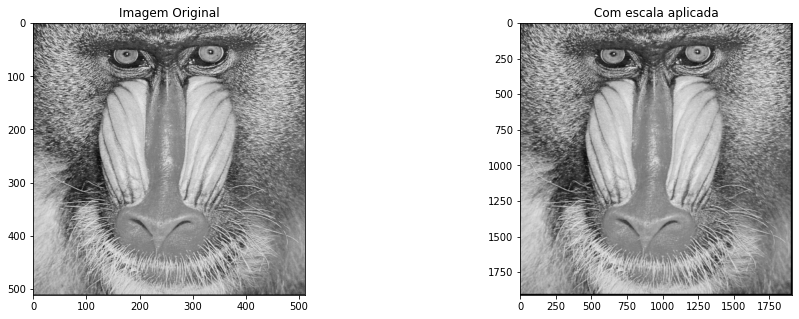

In [36]:
bili_img = geometric_function(new_height, new_width, scale_img, bilinear_interpolation, scale_factor)
plot_transform(img, bili_img)

### Bicúbica

In [37]:
def P_function(t):
  """
  Recebe o valor t e o retorna caso for maior que 0,
  caso contrário retorna 0.
  
  """
  if t > 0:
    t = t
  else:
    t = 0
  return t

def R_function(s):
  t1 = P_function(s + 2) ** 3
  t2 = 4 * P_function(s + 1) ** 3
  t3 = 6 * P_function(s) ** 3
  t4 = 4 * P_function(s - 1) ** 3

  pixel_value = 0.16 * (t1 - t2 + t3 - t4)

  return pixel_value

In [38]:
def bicubic_interpolation(x, y, img):
  ms = [-1,0,1]
  ns = [-1,0,1]

  dx = abs(round(x) - x)
  dy = abs(round(y) - y)

  x = int(x)
  y = int(y)

  pixel_value = 0

  for m in ms:
    for n in ns:
      pixel_value += img[x+m, y+n] * R_function(m-dx) * R_function(dy-n)

  return pixel_value

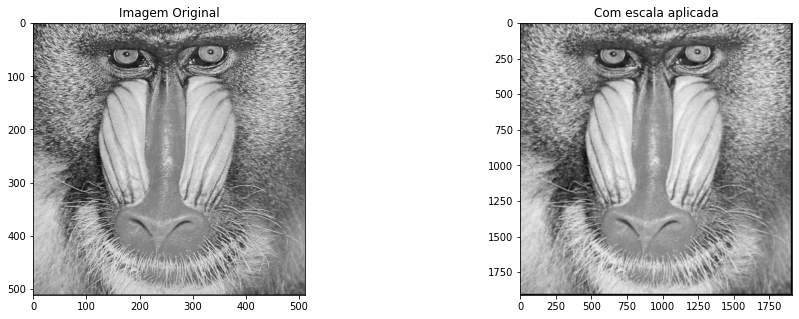

In [39]:
bicubic_img = geometric_function(new_height, new_width, scale_img, bicubic_interpolation, scale_factor)
plot_transform(img, bicubic_img)

### Polinômios de Lagrange

In [40]:
def L_function(n, dx, dy, x, y, img):
  t1 = (-dx *(dx -1) * (dx -2) * img[x-1, y + n -2])/6
  t2 = ((dx + 1) * (dx - 1) * (dx - 2) * img[x, y+ n - 2])/2
  t3 = (-dx*(dx+1) * (dx-2) * img[x+1, y+n-2])/2
  t4 = (dx*(dx+1)*(dx-1)*img[x+2,y+n-2])/6

  L_value = t1 + t2 + t3 + t4

  return L_value

In [41]:
def lagrange_interpolation(x, y, img):
  dx = abs(round(x) - x)
  dy = abs(round(y) - y)

  x = int(x)
  y = int(y)

  t1 = (-dy*(dy-1)*(dy-2)*L_function(1, dx, dy, x, y, img)) / 6
  t2 = ((dy+1)*(dy-1)*(dy-2)*L_function(2, dx, dy, x, y, img) / 2)
  t3 = ((-dy*(dy+1)*(dy-2)*L_function(3, dx, dy, x, y, img)) /2)
  t4 = (dy*(dy+1)*(dy-1)*L_function(4, dx, dy, x, y, img))/6

  pixel_value = t1 + t2 + t3 + t4

  return pixel_value

Text(0.5, 1.0, 'Com escala aplicada')

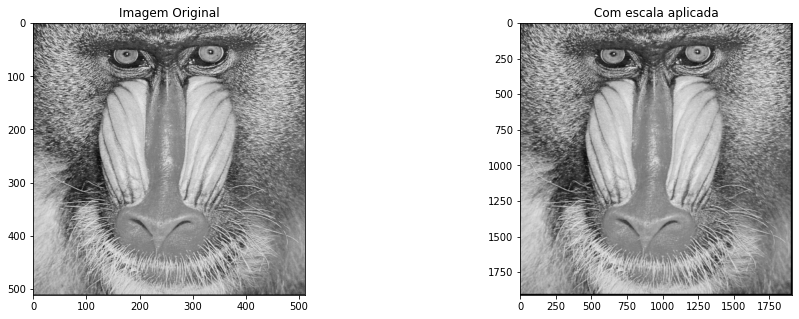

In [45]:
lagrange_img = geometric_function(new_height, new_width, scale_img, lagrange_interpolation, scale_factor)
plot_transform(img, lagrange_img)